# Content extraction

1. Read the cont_image
2. Resize cont_image
3. Preprocess : RGB ->BGR and normalize
4. Create VGG_avg
5. Generate P(l) = activations for the cont_image at layer l
6. Generate F(l) = activations for white noise image at layer l
7. content_loss = MSE(P(l), F(l))

# Style extraction

1. Read the style_image
2. Resize style_image
3. Preprocess : RGB ->BGR and normalize
4. Create VGG_avg
5. Generate Gram_matrix for original image, A(L) =  Inner product of F x Ft for the layers L, 
where F is the vectorized feature map. (There is some weight to the loss for each layer?)
6. Generate Gram_matrix for white noise image, G(L) similarly above 
7. style_loss = MSE(A(L), G(L))

# Style transfer

1. loss(p,a,x) = a x content_loss(p,x) + b x style_loss(a,x), where p=content, a=artwork, x = generated image
2. Run SGD on fmin_l_bfgs_b(loss, x0=x, args=(p,a))

In [1]:
%matplotlib inline
import importlib
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('../PreTrainedModels')
from vgg16_avg import VGG16_Avg

In [3]:
import sys
sys.path.append('../utilities')
import utils2; importlib.reload(utils2)
from utils2 import *

/home/sravya/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
limit_mem()

In [5]:
dpath = '/home/sravya/data/style_transfer/'

# Read images and resize

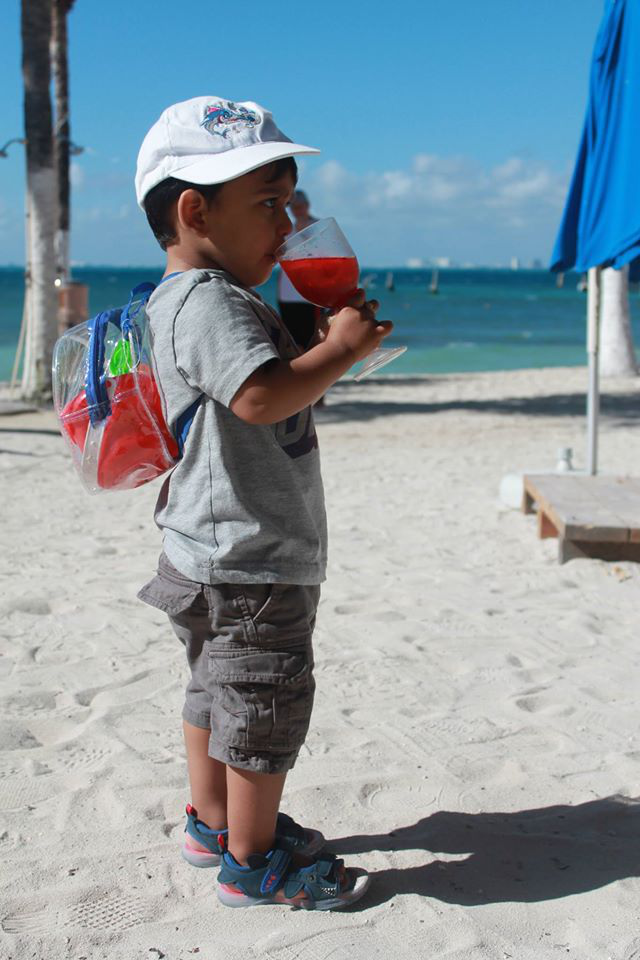

In [6]:
content_img_raw=Image.open(dpath + 'anay.jpg'); content_img_raw

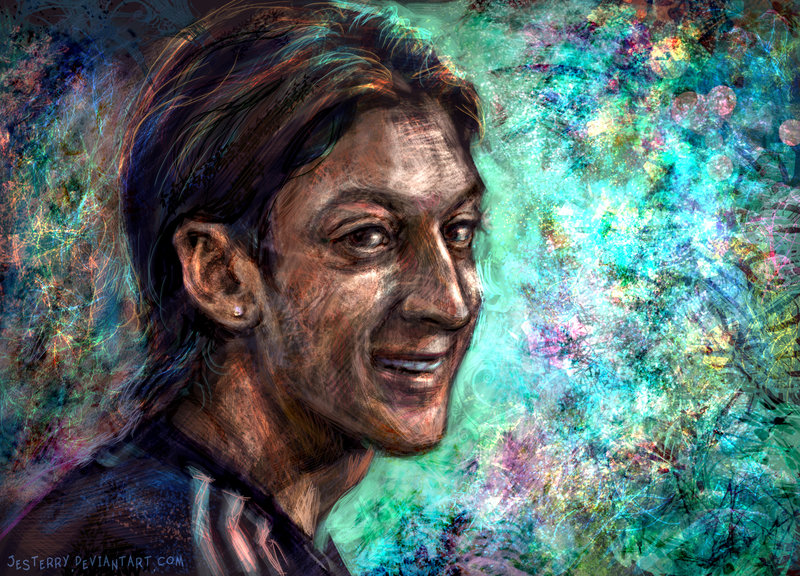

In [7]:
style_img_raw = Image.open(dpath + 'jesterry.jpg');style_img_raw

In [8]:
content_img_raw.size, style_img_raw.size

((640, 960), (800, 576))

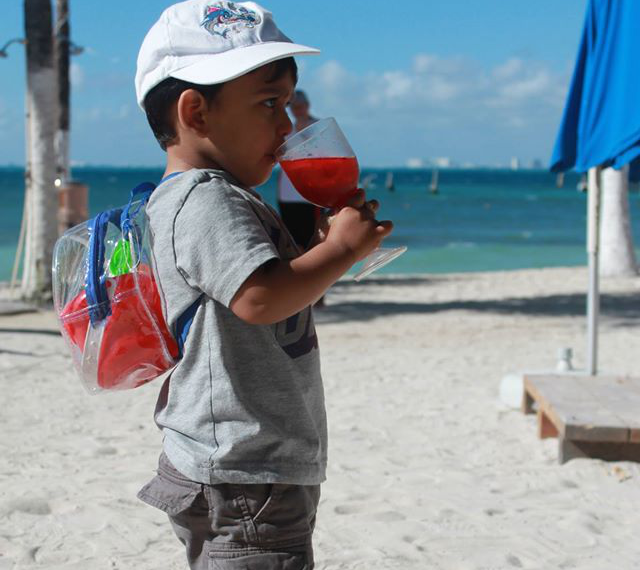

In [9]:
content_img = content_img_raw.crop([0,100,640,570+100]);content_img

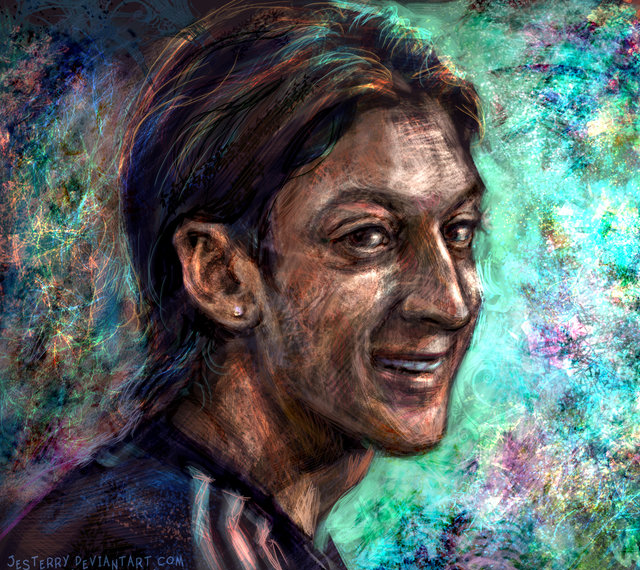

In [10]:
style_img = style_img_raw.crop([0,0,640,570]);style_img

In [11]:
content_img.size,style_img.size

((640, 570), (640, 570))

# Preprocess for VGG

In [12]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [13]:
content_img_arr = preproc(np.expand_dims(np.array(content_img), 0))
style_img_arr = preproc(np.expand_dims(np.array(style_img), 0))

# Create VGG_avg

In [14]:
shp = style_img_arr.shape
#shp = style_img_arr.shape
model = VGG16_Avg(include_top=False, input_shape=shp[1:])

In [15]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 570, 640, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 570, 640, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 570, 640, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (AveragePooling2D)   (None, 285, 320, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

# Create loss and gradients

In [16]:
outputs = {l.name: l.output for l in model.layers}

In [17]:
#Create content and style models
content_layer = outputs['block4_conv2']
content_model = Model(model.input, content_layer)
style_layers = [outputs['block{}_conv1'.format(o)] for o in range(1,6)]
style_model = Model(model.input, style_layers)

In [18]:
#Create content model and generate y_true tensor
content_targ = K.variable(content_model.predict(content_img_arr))

In [19]:
#Create style model and generate y_true tensor
style_targs = [K.variable(o) for o in style_model.predict(style_img_arr)]

In [20]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation 
    # between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [21]:
def style_loss(x, targ): return metrics.mse(gram_matrix(x), gram_matrix(targ))

In [22]:
class Evaluator(object):
    def __init__(self, f, shp): self.f, self.shp = f, shp
        
    def loss(self, x):
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x): return self.grad_values.flatten().astype(np.float64)

In [23]:
loss = sum(style_loss(l1[0], l2[0]) for l1,l2 in zip(style_layers, style_targs))
loss += metrics.mse(content_layer, content_targ)
grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss]+grads)

In [24]:
evaluator = Evaluator(transfer_fn, shp)

# Create white noise image and fit using the evaluator

In [25]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape)/100
x = rand_img(shp)

In [26]:
deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [27]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127,127)
        print('Current loss value:', min_val)
        imsave(f'{dpath}/results/res_at_iteration_{i}.png', deproc(x.copy(), shp)[0])
    return x

In [28]:
x.shape

(1, 570, 640, 3)

In [29]:
x = solve_image(evaluator, 10, x)

Current loss value: 11369.8583984
Current loss value: 3575.61572266
Current loss value: 2486.234375
Current loss value: 1979.66760254
Current loss value: 1683.91625977
Current loss value: 1494.79223633
Current loss value: 1365.34643555
Current loss value: 1271.89257812
Current loss value: 1199.32141113
Current loss value: 1142.62512207


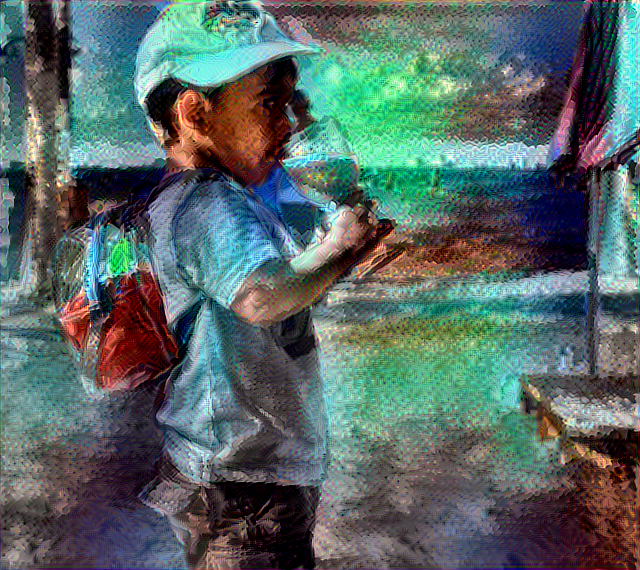

In [35]:
Image.open(dpath + 'results/res_at_iteration_8.png')